### Import libraries

In [1]:
# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
# Pandas
import pandas as pd

# Numpy
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

# Preprocessing
from sklearn.preprocessing import StandardScaler

In [3]:
# Learning algorithms
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Pipeline
from sklearn.pipeline import Pipeline

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# Metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_samples

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection # Randomized Projections
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture # Expectation Maximization

### Load Data

In [4]:
spambase_df = pd.read_csv('./data/spambase.data', header=None, error_bad_lines=False)

# Full Data
X = spambase_df.iloc[:, :-1].values
y = spambase_df.iloc[:, -1].values

# Split data into train and test
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=42)

### Plotting Functions

In [5]:
def plot_variance(var_exp, cum_var_exp, title=None, save_as=None):
    plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(1, len(var_exp)+1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Components')
    plt.legend(loc='best')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [6]:
def plot_decision_regions(X, y, classifier, resolution=0.02, title=None, save_as=None):
    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.title(title)
    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [7]:
def plot_elbow_distortions(max_clusters, X, title=None, save_as=None):
    distortions = []
    for i in range(1, max_clusters+1):
        km = KMeans(n_clusters=i, 
                    init='k-means++', 
                    n_init=10, 
                    max_iter=300, 
                    random_state=42)
        km.fit(X)
        distortions.append(km.inertia_)
    plt.plot(range(1, max_clusters+1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [8]:
def plot_elbow_bic(max_components, X, title=None, save_as=None):
    bic = []
    for i in range(1, max_components+1):
        gmm = GaussianMixture(n_components=i, 
                              covariance_type='full',
                              reg_covar=1e-06, 
                              max_iter=100, 
                              n_init=1, 
                              init_params='kmeans',
                              random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
    plt.plot(range(1, max_components+1), bic, marker='s')
    plt.xlabel('Number of Components')
    plt.ylabel('Bayesian Information Criterion')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [9]:
def plot_silhouette(km, X, title=None, save_as=None):
    y_km = km.predict(X)
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="orange", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette Coefficient')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [10]:
def plot_kmeans(km, X, xlim=None, ylim=None, title=None, save_as=None):
    y_km = km.predict(X)
    colors = ('lightgreen', 'purple', 'blue', 'orange')
    markers = ('s', 'o', 'v', 'p')
    for i in range(0, km.n_clusters):
        plt.scatter(X[y_km == i, 0],
                    X[y_km == i, 1],
                    s=50, c=colors[i],
                    marker=markers[i], edgecolor='black',
                    label='cluster '+str(i+1))
    plt.scatter(km.cluster_centers_[:, 0],
                km.cluster_centers_[:, 1],
                s=250, marker='*',
                c='red', edgecolor='black',
                label='centroids')
    
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [11]:
def plot_gmm(gmm, X, index, xlim=None, ylim=None, title=None, save_as=None):
    import itertools
    from scipy import linalg
    import matplotlib as mpl
    
    y_gmm = gmm.predict(X)
    color_iter = itertools.cycle(['green', 'blue', 'orange', 'purple'])
    means = gmm.means_
    covariances = gmm.covariances_
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(y_gmm == i):
            continue
        plt.scatter(X[y_gmm == i, 0], X[y_gmm == i, 1], color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_alpha(0.5)

    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [12]:
def plot_discriminability(eigen_vals, ylim=None, save_as=None):
    tot = sum(eigen_vals.real)
    discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
    cum_discr = np.cumsum(discr)

    plt.bar(range(0, len(eigen_vals)), discr, alpha=0.5, align='center',
            label='individual class-discriminatory information ratio')
    plt.step(range(0, len(eigen_vals)), cum_discr, where='mid',
             label='cumulative class-discriminatory information ratio')
    plt.ylabel('Class-discriminatory Information Ratio')
    plt.xlabel('Linear Discriminants')
    plt.ylim(ylim)
    plt.legend(loc='best')
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [13]:
train_auc_list = []
test_auc_list = []

## Clustering Algorithms

### K-Means

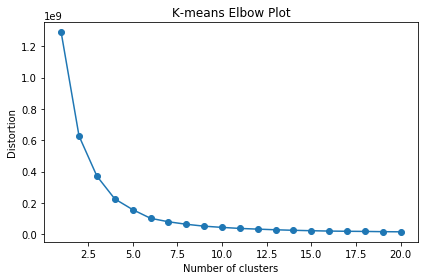

In [14]:
# Elbow around k=4
plot_elbow_distortions(max_clusters=20, X=X_train, title='K-means Elbow Plot', save_as='Spambase/kmeans_elbow_plot')

In [15]:
kmeans = KMeans(n_clusters=4, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [16]:
%%time
kmeans.fit(X_train)

Wall time: 2.46 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [17]:
X_train_kmeans = kmeans.predict(X_train).reshape(-1, 1)
X_test_kmeans = kmeans.predict(X_test).reshape(-1, 1)

In [18]:
%%time
# Kmeans data only
pipe_mlp = Pipeline([('scl', StandardScaler()),
                     ('clf', MLPClassifier(max_iter=1000, 
                                           activation='relu', 
                                           solver='adam', 
                                           hidden_layer_sizes=(120,), 
                                           random_state=42))])

pipe_mlp.fit(X_train_kmeans, y_train)

Wall time: 300 ms


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(120,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [19]:
print('Train Accuracy: %.3f' % pipe_mlp.score(X_train_kmeans, y_train))
print('Test Accuracy: %.3f' % pipe_mlp.score(X_test_kmeans, y_test))

y_pred = pipe_mlp.predict(X_train_kmeans)
print('Train AUC: %.3f' % roc_auc_score(y_train, y_pred))
train_auc_list.append(roc_auc_score(y_train, y_pred))

y_pred = pipe_mlp.predict(X_test_kmeans)
print('Test AUC: %.3f' % roc_auc_score(y_test, y_pred))
test_auc_list.append(roc_auc_score(y_test, y_pred))

Train Accuracy: 0.668
Test Accuracy: 0.637
Train AUC: 0.590
Test AUC: 0.576


In [20]:
X_train_kmeans_combined = np.concatenate([X_train, X_train_kmeans], axis=1)
X_test_kmeans_combined = np.concatenate([X_test, X_test_kmeans], axis=1)

In [21]:
%%time
# Kmeans combined with original data
pipe_mlp = Pipeline([('scl', StandardScaler()),
                     ('clf', MLPClassifier(max_iter=1000, 
                                           activation='relu', 
                                           solver='adam', 
                                           hidden_layer_sizes=(120,), 
                                           random_state=42))])

pipe_mlp.fit(X_train_kmeans_combined, y_train)

Wall time: 6.96 s


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(120,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [22]:
print('Train Accuracy: %.3f' % pipe_mlp.score(X_train_kmeans_combined, y_train))
print('Test Accuracy: %.3f' % pipe_mlp.score(X_test_kmeans_combined, y_test))

y_pred = pipe_mlp.predict(X_train_kmeans_combined)
print('Train AUC: %.3f' % roc_auc_score(y_train, y_pred))
train_auc_list.append(roc_auc_score(y_train, y_pred))

y_pred = pipe_mlp.predict(X_test_kmeans_combined)
print('Test AUC: %.3f' % roc_auc_score(y_test, y_pred))
test_auc_list.append(roc_auc_score(y_test, y_pred))

Train Accuracy: 0.994
Test Accuracy: 0.960
Train AUC: 0.993
Test AUC: 0.957


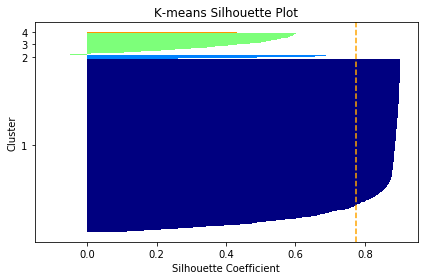

In [23]:
plot_silhouette(km=kmeans, X=X_train, title='K-means Silhouette Plot', save_as='Spambase/silhouette_plot')

### Expectation Maximization (Gaussian Mixture)

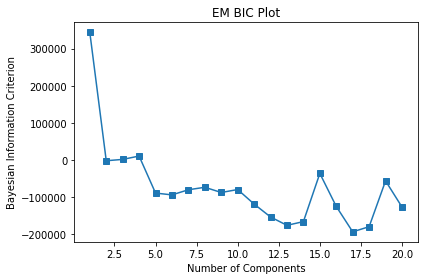

In [24]:
plot_elbow_bic(max_components=20, X=X_train, title='EM BIC Plot', save_as='Spambase/EM_BIC_plot')

In [25]:
gaussian_mix = GaussianMixture(n_components=5, covariance_type='full', 
                               max_iter=100, init_params='kmeans', 
                               random_state=42, verbose=0, verbose_interval=10)

In [26]:
%%time
gaussian_mix.fit(X_train)

Wall time: 1.26 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [27]:
X_train_gmm = gaussian_mix.predict(X_train).reshape(-1, 1)
X_test_gmm = gaussian_mix.predict(X_test).reshape(-1, 1)

In [28]:
%%time
# EM data only
pipe_mlp = Pipeline([('scl', StandardScaler()),
                     ('clf', MLPClassifier(max_iter=1000, 
                                           activation='relu', 
                                           solver='adam', 
                                           hidden_layer_sizes=(120,), 
                                           random_state=42))])

pipe_mlp.fit(X_train_gmm, y_train)

Wall time: 1.45 s


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(120,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [29]:
print('Train Accuracy: %.3f' % pipe_mlp.score(X_train_gmm, y_train))
print('Test Accuracy: %.3f' % pipe_mlp.score(X_test_gmm, y_test))

y_pred = pipe_mlp.predict(X_train_gmm)
print('Train AUC: %.3f' % roc_auc_score(y_train, y_pred))
train_auc_list.append(roc_auc_score(y_train, y_pred))

y_pred = pipe_mlp.predict(X_test_gmm)
print('Test AUC: %.3f' % roc_auc_score(y_test, y_pred))
test_auc_list.append(roc_auc_score(y_test, y_pred))

Train Accuracy: 0.781
Test Accuracy: 0.803
Train AUC: 0.790
Test AUC: 0.807


In [30]:
X_train_gmm_combined = np.concatenate([X_train, X_train_gmm], axis=1)
X_test_gmm_combined = np.concatenate([X_test, X_test_gmm], axis=1)

In [31]:
%%time
# EM combined with original data
pipe_mlp = Pipeline([('scl', StandardScaler()),
                     ('clf', MLPClassifier(max_iter=1000, 
                                           activation='relu', 
                                           solver='adam', 
                                           hidden_layer_sizes=(120,), 
                                           random_state=42))])

pipe_mlp.fit(X_train_gmm_combined, y_train)

Wall time: 6.9 s


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(120,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [32]:
print('Train Accuracy: %.3f' % pipe_mlp.score(X_train_gmm_combined, y_train))
print('Test Accuracy: %.3f' % pipe_mlp.score(X_test_gmm_combined, y_test))

y_pred = pipe_mlp.predict(X_train_gmm_combined)
print('Train AUC: %.3f' % roc_auc_score(y_train, y_pred))
train_auc_list.append(roc_auc_score(y_train, y_pred))

y_pred = pipe_mlp.predict(X_test_gmm_combined)
print('Test AUC: %.3f' % roc_auc_score(y_test, y_pred))
test_auc_list.append(roc_auc_score(y_test, y_pred))

Train Accuracy: 0.995
Test Accuracy: 0.956
Train AUC: 0.994
Test AUC: 0.953


## Dimensionality Reduction Algorithms

### Principal Component Analysis

In [33]:
pca = PCA(n_components=2, copy=True, 
          whiten=False, svd_solver='auto', 
          tol=0.0, iterated_power='auto', 
          random_state=42)

In [34]:
%%time
X_train_pca = pca.fit_transform(X_train)

Wall time: 14 ms


In [35]:
X_test_pca = pca.transform(X_test)

In [36]:
%%time
pipe_mlp = Pipeline([('scl', StandardScaler()),
                     ('clf', MLPClassifier(max_iter=1000, 
                                           activation='relu', 
                                           solver='adam', 
                                           hidden_layer_sizes=(120,), 
                                           random_state=42))])

pipe_mlp.fit(X_train_pca, y_train)

Wall time: 2.57 s


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(120,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [37]:
print('Train Accuracy: %.3f' % pipe_mlp.score(X_train_pca, y_train))
print('Test Accuracy: %.3f' % pipe_mlp.score(X_test_pca, y_test))

y_pred = pipe_mlp.predict(X_train_pca)
print('Train AUC: %.3f' % roc_auc_score(y_train, y_pred))
train_auc_list.append(roc_auc_score(y_train, y_pred))

y_pred = pipe_mlp.predict(X_test_pca)
print('Test AUC: %.3f' % roc_auc_score(y_test, y_pred))
test_auc_list.append(roc_auc_score(y_test, y_pred))

Train Accuracy: 0.755
Test Accuracy: 0.749
Train AUC: 0.732
Test AUC: 0.732


### Independent Component Analysis

In [38]:
ica = FastICA(n_components=4, algorithm='parallel', 
              whiten=True, fun='logcosh', fun_args=None, 
              max_iter=200, tol=0.0001, w_init=None, 
              random_state=42)

In [39]:
%%time
X_train_ica = ica.fit_transform(X_train)

Wall time: 38.9 ms


In [40]:
X_test_ica = ica.transform(X_test)

In [41]:
%%time
pipe_mlp = MLPClassifier(max_iter=1000, 
                    activation='relu', 
                    solver='adam', 
                    hidden_layer_sizes=(120,), 
                    random_state=42)

pipe_mlp.fit(X_train_ica, y_train)

Wall time: 8.04 s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(120,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [42]:
print('Train Accuracy: %.3f' % pipe_mlp.score(X_train_ica, y_train))
print('Test Accuracy: %.3f' % pipe_mlp.score(X_test_ica, y_test))

y_pred = pipe_mlp.predict(X_train_ica)
print('Train AUC: %.3f' % roc_auc_score(y_train, y_pred))
train_auc_list.append(roc_auc_score(y_train, y_pred))

y_pred = pipe_mlp.predict(X_test_ica)
print('Test AUC: %.3f' % roc_auc_score(y_test, y_pred))
test_auc_list.append(roc_auc_score(y_test, y_pred))

Train Accuracy: 0.820
Test Accuracy: 0.808
Train AUC: 0.808
Test AUC: 0.797


### Random Projection (Gaussian)

In [43]:
grp = GaussianRandomProjection(n_components=23, 
                               eps=0.1, 
                               random_state=42)

In [44]:
%%time
X_train_grp = grp.fit_transform(X_train)

Wall time: 2 ms


In [45]:
X_test_grp = grp.transform(X_test)

In [46]:
%%time
pipe_mlp = Pipeline([('scl', StandardScaler()),
                     ('clf', MLPClassifier(max_iter=1000, 
                                           activation='relu', 
                                           solver='adam', 
                                           hidden_layer_sizes=(120,), 
                                           random_state=42))])

pipe_mlp.fit(X_train_grp, y_train)

Wall time: 5.15 s


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(120,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [47]:
print('Train Accuracy: %.3f' % pipe_mlp.score(X_train_grp, y_train))
print('Test Accuracy: %.3f' % pipe_mlp.score(X_test_grp, y_test))

y_pred = pipe_mlp.predict(X_train_grp)
print('Train AUC: %.3f' % roc_auc_score(y_train, y_pred))
train_auc_list.append(roc_auc_score(y_train, y_pred))

y_pred = pipe_mlp.predict(X_test_grp)
print('Test AUC: %.3f' % roc_auc_score(y_test, y_pred))
test_auc_list.append(roc_auc_score(y_test, y_pred))

Train Accuracy: 0.883
Test Accuracy: 0.872
Train AUC: 0.872
Test AUC: 0.863


### Linear Discriminant Analysis

In [48]:
lda = LinearDiscriminantAnalysis(n_components=1, 
                                 solver='svd', 
                                 store_covariance=False, 
                                 tol=0.0001)

In [49]:
%%time
X_train_lda = lda.fit_transform(X_train, y_train)

Wall time: 43.9 ms


In [50]:
X_test_lda = lda.transform(X_test)

In [51]:
%%time
pipe_mlp = Pipeline([('scl', StandardScaler()),
                     ('clf', MLPClassifier(max_iter=1000, 
                                           activation='relu', 
                                           solver='adam', 
                                           hidden_layer_sizes=(120,), 
                                           random_state=42))])

pipe_mlp.fit(X_train_lda, y_train)

Wall time: 1.05 s


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(120,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [52]:
print('Train Accuracy: %.3f' % pipe_mlp.score(X_train_lda, y_train))
print('Test Accuracy: %.3f' % pipe_mlp.score(X_test_lda, y_test))

y_pred = pipe_mlp.predict(X_train_lda)
print('Train AUC: %.3f' % roc_auc_score(y_train, y_pred))
train_auc_list.append(roc_auc_score(y_train, y_pred))

y_pred = pipe_mlp.predict(X_test_lda)
print('Test AUC: %.3f' % roc_auc_score(y_test, y_pred))
test_auc_list.append(roc_auc_score(y_test, y_pred))

Train Accuracy: 0.911
Test Accuracy: 0.910
Train AUC: 0.905
Test AUC: 0.906


### Random Forest Feature Selection

In [53]:
%%time
feat_labels = spambase_df.columns[:-1]
forest = RandomForestClassifier(n_estimators=500,
                                random_state=42)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

Wall time: 2.66 s


In [54]:
X_train_rf = X_train[:, indices[:22]]
X_test_rf = X_test[:, indices[:22]]

In [55]:
%%time
pipe_mlp = Pipeline([('scl', StandardScaler()),
                     ('clf', MLPClassifier(max_iter=1000, 
                                           activation='relu', 
                                           solver='adam', 
                                           hidden_layer_sizes=(120,), 
                                           random_state=42))])

pipe_mlp.fit(X_train_rf, y_train)

Wall time: 10.8 s


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(120,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [76]:
print('Train Accuracy: %.3f' % pipe_mlp.score(X_train_rf, y_train))
print('Test Accuracy: %.3f' % pipe_mlp.score(X_test_rf, y_test))

y_pred = pipe_mlp.predict(X_train_rf)
print('Train AUC: %.3f' % roc_auc_score(y_train, y_pred))
train_auc_list.append(roc_auc_score(y_train, y_pred))

y_pred = pipe_mlp.predict(X_test_rf)
print('Test AUC: %.3f' % roc_auc_score(y_test, y_pred))
test_auc_list.append(roc_auc_score(y_test, y_pred))

Train Accuracy: 0.990
Test Accuracy: 0.930
Train AUC: 0.988
Test AUC: 0.925


### Overall Results

In [126]:
labels_list = ['K-means Only', 'K-means Augmented', 'EM Only', 'EM Augmented', 'PCA', 'ICA', 'GRP', 'LDA', 'RF']
training_times_list = [2.76, 9.42, 2.71, 8.16, 2.58, 8.43, 5.15, 1.09, 13.46]
time_zipped = zip(labels_list, training_times_list)
time_sorted = sorted(time_zipped, key=lambda x:x[1], reverse=True)

test_zipped = zip(labels_list, test_auc_list)
test_sorted = sorted(test_zipped, key=lambda x:x[1])

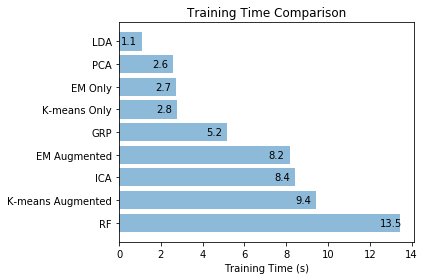

In [154]:
y_pos = np.arange(len(labels_list))
plt.barh(y_pos, [times for labels, times in time_sorted], align='center', alpha=0.5)
plt.yticks(y_pos, [labels for labels, times in time_sorted])
plt.xlabel('Training Time (s)')
plt.title('Training Time Comparison')
for i, v in enumerate([times for labels, times in time_sorted]):
    plt.text(v-1, i, "%.1f" % v, color='black', va='center')
plt.tight_layout()
save_as = 'Spambase/NN_time_comparison'
plt.savefig('./figures/' + save_as + '.png', dpi=300)
plt.show()

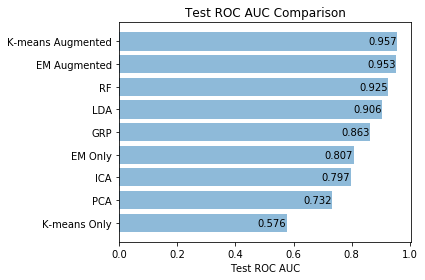

In [155]:
y_pos = np.arange(len(labels_list))
plt.barh(y_pos, [auc for labels, auc in test_sorted], align='center', alpha=0.5)
plt.yticks(y_pos, [labels for labels, auc in test_sorted])
plt.xlabel('Test ROC AUC')
plt.title('Test ROC AUC Comparison')
for i, v in enumerate([auc for labels, auc in test_sorted]):
    plt.text(v-0.1, i, "%.3f" % v, color='black', va='center')
plt.tight_layout()
save_as = 'Spambase/NN_test_auc_comparison'
plt.savefig('./figures/' + save_as + '.png', dpi=300)
plt.show()